<a href="https://colab.research.google.com/github/PatrickPasolini/MLDM_Lab/blob/main/Kaggle/KAGGLE/Data_analysis_and_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Analysis and Preprocessing

## Imports

The autoreload instruction reloads modules automatically before code execution, which is helpful for the update below.

In [1]:
%load_ext autoreload
%autoreload 2

Make sure that we have the latest version of pandas-profiling and scikit-learn.

In [4]:
import sys

!{sys.executable} -m pip install -U pandas-profiling[notebook]
!jupyter nbextension enable --py widgetsnbextension

#!pip uninstall scikit-learn -y
#!pip install -U scikit-learn
#!pip install https://github.com/ydataai/pandas-profiling/archive/master.zip

Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [6]:
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn as sk
from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.tree import DecisionTreeClassifier

import requests
#import pandas_profiling as pp
#from pandas_profiling.utils.cache import cache_file

In [7]:
print(sk.__version__)

print(pd.__version__)

1.6.1
2.2.2


## Constants

In [18]:
DATA_PATH = "https://raw.githubusercontent.com/serivan/mldmlab/master/Kaggle/KAGGLE/" #dataset su cui lavoriamo
#il target è sempre 1 perchè dobbiamo identificarlo noi, non è realmente sempre 1
# sampleSubmission: id,target
RANDOM_STATE = 3993  # stato per avere risultati deterministici per garantire la riproducibilità
COLLINEAR_THRESHOLD = 0.9
K_FEATURES = 3


## Load Data
carico il training set

In [20]:
dataset = pd.read_csv(DATA_PATH + "train.csv")

# Save the target column and drop the target
target = dataset["target"]
dataset.drop(columns="target", inplace=True)
# Sort columns by name
dataset.sort_index(axis="columns", inplace=True)
# Print first samples
dataset

#OSS. sotto si possono far generare i grafici consigliati e se vai sopra mostra il codice

Id   age  chest_pain_type  cholesterol  exercise_angina  \
0     1000  62.0              2.0        213.0              0.0   
1     1001  72.0              3.0          2.0              0.0   
2     1002  49.0              3.0        183.0              0.0   
3     1003  35.0              2.0          NaN              0.0   
4     1004  51.0              4.0         -4.0              0.0   
...    ...   ...              ...          ...              ...   
1296  2296  66.0              4.0        227.0              0.0   
1297  2297  51.0              3.0        251.0              0.0   
1298  2298  42.0              2.0        294.0              0.0   
1299  2299  41.0              2.0        161.0              0.0   
1300  2300  53.0              3.0        245.0              0.0   

      fasting_blood_sugar  max_heart_rate   oldpeak  pulse  resting_bp_s  \
0                     1.0           141.0 -0.051026  348.0         128.0   
1                     0.0           115.0  1.626599  287.0         159.0   
2                     0.0           156.0  0.968111  391.0         161.0   
3                     0.0           179.0  0.021913  449.0         119.0   
4                     1.0           104.0 -0.010970  258.0         120.0   
...                   ...             ...       ...    ...           ...   
1296                  0.0           137.0  2.333775  343.0         161.0   
1297                  0.0           148.0  0.530301  376.0         130.0   
1298                  0.0           161.0 -0.011372  406.0         121.0   
1299                  0.0           183.0 -0.025241  454.0         120.0   
1300                  1.0           173.0 -0.001958  431.0         131.0   

      resting_ecg  sex  st_slope      synt  
0             2.0  1.0       1.0  0.536459  
1             2.0  1.0       2.0  0.334897  
2             0.0  0.0       2.0  0.720858  
3             2.0  1.0       1.0  0.117560  
4             0.0  1.0       2.0  0.790254  
...           ...  ...       ...       ...  
1296          2.0  1.0       1.0  0.585738  
1297          2.0  0.0       1.0  0.318384  
1298          0.0  1.0       1.0  0.849485  
1299          0.0  1.0       1.0  0.435816  
1300          2.0  1.0       1.0  0.405372  

[1301 rows x 14 columns]

## Missing Values

Reasons for missing values
- Information is not collected (e.g., people decline to give their age and weight)
- Attributes may not be applicable to all cases (e.g., annual income is not applicable to children)

Handling missing values
- Eliminate Data Objects
- Estimate Missing Values
- Ignore the Missing Value During Analysis
- Replace with all possible values (weighted by their probabilities)

In [26]:
def count_missing(ds: pd.DataFrame):
    return ds.shape[0] - ds.count()  # numero di righe - numero di righe non missing

In [24]:
count_missing(dataset)

Id                       0
age                      4
chest_pain_type          9
cholesterol            202
exercise_angina          3
fasting_blood_sugar     11
max_heart_rate           7
oldpeak                  8
pulse                    3
resting_bp_s             7
resting_ecg              3
sex                      8
st_slope                 1
synt                     0
dtype: int64

<Axes: >

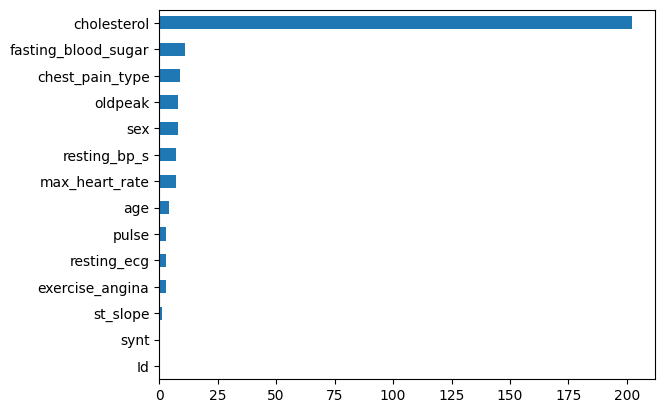

In [54]:
# Better visualization for missing count sorted by column
count_missing(dataset).sort_values().plot.barh()

In [28]:
# righe che hanno un NotANumber
def get_sample_with_nans(ds: pd.DataFrame):
    return ds.loc[ds.isna().any(axis=1)]

In [29]:
get_sample_with_nans(dataset)

Id   age  chest_pain_type  cholesterol  exercise_angina  \
3     1003  35.0              2.0          NaN              0.0   
6     1006  66.0              4.0          NaN              0.0   
8     1008  65.0              1.0          NaN              0.0   
10    1010  41.0              2.0          NaN              0.0   
13    1013  54.0              4.0          NaN              1.0   
...    ...   ...              ...          ...              ...   
1274  2274  44.0              2.0          NaN              0.0   
1278  2278  63.0              NaN         -3.0              0.0   
1280  2280  60.0              NaN        254.0              0.0   
1289  2289  45.0              2.0          NaN              0.0   
1295  2295  44.0              3.0        230.0              0.0   

      fasting_blood_sugar  max_heart_rate   oldpeak  pulse  resting_bp_s  \
3                     0.0           179.0  0.021913  449.0         119.0   
6                     0.0           141.0  1.480206  347.0         113.0   
8                     0.0           134.0  0.261265  337.0         141.0   
10                    0.0           162.0  0.021463  407.0         126.0   
13                    0.0           117.0  1.451523  294.0         131.0   
...                   ...             ...       ...    ...           ...   
1274                  0.0           136.0 -0.018937  338.0         129.0   
1278                  1.0           154.0  3.648962  388.0         149.0   
1280                  0.0           156.0  2.630425  392.0         150.0   
1289                  0.0           169.0  0.015662  422.0         127.0   
1295                  0.0           168.0  0.023068  422.0         119.0   

      resting_ecg  sex  st_slope      synt  
3             2.0  1.0       1.0  0.117560  
6             0.0  1.0       1.0  0.204944  
8             0.0  1.0       1.0  0.854541  
10            0.0  0.0       1.0  0.013972  
13            1.0  1.0       2.0  0.844455  
...           ...  ...       ...       ...  
1274          0.0  1.0       1.0  0.328454  
1278          1.0  1.0       1.0  0.457896  
1280          2.0  0.0       2.0  0.886322  
1289          2.0  1.0       1.0  0.602137  
1295          0.0  NaN       1.0  0.001392  

[262 rows x 14 columns]

In [42]:
sample_with_nans_ids = get_sample_with_nans(dataset).index
sample_with_nans_ids

Index([   3,    6,    8,   10,   13,   20,   27,   29,   32,   34,
       ...
       1248, 1249, 1253, 1254, 1269, 1274, 1278, 1280, 1289, 1295],
      dtype='int64', length=262)

### Eliminate Data Objects

In [39]:
print(dataset.shape)
dataset_no_nans = dataset.dropna() #restituisce i dati senza NaN ma non modifica il dataset
dataset_no_nans
print(dataset_no_nans.shape)
print("numero elementi eliminati",dataset.shape[0] - dataset_no_nans.shape[0])


(1301, 14)
(1039, 14)
numero elementi eliminati 262


In [40]:
count_missing(dataset_no_nans)

Id                     0
age                    0
chest_pain_type        0
cholesterol            0
exercise_angina        0
fasting_blood_sugar    0
max_heart_rate         0
oldpeak                0
pulse                  0
resting_bp_s           0
resting_ecg            0
sex                    0
st_slope               0
synt                   0
dtype: int64

In [45]:
try:
    dataset_no_nans.loc[sample_with_nans_ids]
except KeyError:
    print("Ids of desired samples are not in dataset!")

Ids of desired samples are not in dataset!


### Impute Missing Values

Estimate missing values can be performed using both pandas and scikit-learn.
We use scikit-learn because it helps with machine learning.
Perchè eliminarli va bene finchè sono pochi i dati mancanti

In [46]:
def array_to_dataframe(arr: np.ndarray, columns: List[str]):
    return pd.DataFrame(data=arr, columns=columns)

#### Impute with constant

In [56]:
#imputer sono funzioni che trasformano i nostri dati, in questo caso sostituiamo i Nan con -1 in quanto è un valore non ammissibile
#il fit è da fare solo sui dati di training! non sui dati di testing
constant_imp_arr = SimpleImputer(strategy="constant", fill_value=-1).fit_transform(
    dataset
)
constant_imp_arr

array([[1.00000000e+03, 6.20000000e+01, 2.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 5.36459125e-01],
       [1.00100000e+03, 7.20000000e+01, 3.00000000e+00, ...,
        1.00000000e+00, 2.00000000e+00, 3.34896503e-01],
       [1.00200000e+03, 4.90000000e+01, 3.00000000e+00, ...,
        0.00000000e+00, 2.00000000e+00, 7.20857711e-01],
       ...,
       [2.29800000e+03, 4.20000000e+01, 2.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 8.49484851e-01],
       [2.29900000e+03, 4.10000000e+01, 2.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 4.35816087e-01],
       [2.30000000e+03, 5.30000000e+01, 3.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 4.05372091e-01]])


Sostituisco i Nan con la mediana

In [57]:
constant_imp_arr = SimpleImputer(strategy="median").fit_transform(
    dataset
)
constant_imp_arr

array([[1.00000000e+03, 6.20000000e+01, 2.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 5.36459125e-01],
       [1.00100000e+03, 7.20000000e+01, 3.00000000e+00, ...,
        1.00000000e+00, 2.00000000e+00, 3.34896503e-01],
       [1.00200000e+03, 4.90000000e+01, 3.00000000e+00, ...,
        0.00000000e+00, 2.00000000e+00, 7.20857711e-01],
       ...,
       [2.29800000e+03, 4.20000000e+01, 2.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 8.49484851e-01],
       [2.29900000e+03, 4.10000000e+01, 2.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 4.35816087e-01],
       [2.30000000e+03, 5.30000000e+01, 3.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 4.05372091e-01]])

In [62]:
constant_imp_df = array_to_dataframe(constant_imp_arr, dataset.columns)

In [59]:
count_missing(constant_imp_df)

Id                     0
age                    0
chest_pain_type        0
cholesterol            0
exercise_angina        0
fasting_blood_sugar    0
max_heart_rate         0
oldpeak                0
pulse                  0
resting_bp_s           0
resting_ecg            0
sex                    0
st_slope               0
synt                   0
dtype: int64

In [61]:
constan_imp_df.loc[sample_with_nans_ids]

Id   age  chest_pain_type  cholesterol  exercise_angina  \
3     1003.0  35.0              2.0        230.0              0.0   
6     1006.0  66.0              4.0        230.0              0.0   
8     1008.0  65.0              1.0        230.0              0.0   
10    1010.0  41.0              2.0        230.0              0.0   
13    1013.0  54.0              4.0        230.0              1.0   
...      ...   ...              ...          ...              ...   
1274  2274.0  44.0              2.0        230.0              0.0   
1278  2278.0  63.0              3.0         -3.0              0.0   
1280  2280.0  60.0              3.0        254.0              0.0   
1289  2289.0  45.0              2.0        230.0              0.0   
1295  2295.0  44.0              3.0        230.0              0.0   

      fasting_blood_sugar  max_heart_rate   oldpeak  pulse  resting_bp_s  \
3                     0.0           179.0  0.021913  449.0         119.0   
6                     0.0           141.0  1.480206  347.0         113.0   
8                     0.0           134.0  0.261265  337.0         141.0   
10                    0.0           162.0  0.021463  407.0         126.0   
13                    0.0           117.0  1.451523  294.0         131.0   
...                   ...             ...       ...    ...           ...   
1274                  0.0           136.0 -0.018937  338.0         129.0   
1278                  1.0           154.0  3.648962  388.0         149.0   
1280                  0.0           156.0  2.630425  392.0         150.0   
1289                  0.0           169.0  0.015662  422.0         127.0   
1295                  0.0           168.0  0.023068  422.0         119.0   

      resting_ecg  sex  st_slope      synt  
3             2.0  1.0       1.0  0.117560  
6             0.0  1.0       1.0  0.204944  
8             0.0  1.0       1.0  0.854541  
10            0.0  0.0       1.0  0.013972  
13            1.0  1.0       2.0  0.844455  
...           ...  ...       ...       ...  
1274          0.0  1.0       1.0  0.328454  
1278          1.0  1.0       1.0  0.457896  
1280          2.0  0.0       2.0  0.886322  
1289          2.0  1.0       1.0  0.602137  
1295          0.0  1.0       1.0  0.001392  

[262 rows x 14 columns]

#### Impute with mean or median

In [63]:
median_imp_arr = SimpleImputer(strategy="median").fit_transform(dataset)
median_imp_df = array_to_dataframe(arr=median_imp_arr, columns=dataset.columns)
median_imp_df

Id   age  chest_pain_type  cholesterol  exercise_angina  \
0     1000.0  62.0              2.0        213.0              0.0   
1     1001.0  72.0              3.0          2.0              0.0   
2     1002.0  49.0              3.0        183.0              0.0   
3     1003.0  35.0              2.0        230.0              0.0   
4     1004.0  51.0              4.0         -4.0              0.0   
...      ...   ...              ...          ...              ...   
1296  2296.0  66.0              4.0        227.0              0.0   
1297  2297.0  51.0              3.0        251.0              0.0   
1298  2298.0  42.0              2.0        294.0              0.0   
1299  2299.0  41.0              2.0        161.0              0.0   
1300  2300.0  53.0              3.0        245.0              0.0   

      fasting_blood_sugar  max_heart_rate   oldpeak  pulse  resting_bp_s  \
0                     1.0           141.0 -0.051026  348.0         128.0   
1                     0.0           115.0  1.626599  287.0         159.0   
2                     0.0           156.0  0.968111  391.0         161.0   
3                     0.0           179.0  0.021913  449.0         119.0   
4                     1.0           104.0 -0.010970  258.0         120.0   
...                   ...             ...       ...    ...           ...   
1296                  0.0           137.0  2.333775  343.0         161.0   
1297                  0.0           148.0  0.530301  376.0         130.0   
1298                  0.0           161.0 -0.011372  406.0         121.0   
1299                  0.0           183.0 -0.025241  454.0         120.0   
1300                  1.0           173.0 -0.001958  431.0         131.0   

      resting_ecg  sex  st_slope      synt  
0             2.0  1.0       1.0  0.536459  
1             2.0  1.0       2.0  0.334897  
2             0.0  0.0       2.0  0.720858  
3             2.0  1.0       1.0  0.117560  
4             0.0  1.0       2.0  0.790254  
...           ...  ...       ...       ...  
1296          2.0  1.0       1.0  0.585738  
1297          2.0  0.0       1.0  0.318384  
1298          0.0  1.0       1.0  0.849485  
1299          0.0  1.0       1.0  0.435816  
1300          2.0  1.0       1.0  0.405372  

[1301 rows x 14 columns]

In [53]:
count_missing(median_imp_df)

Id                     0
age                    0
chest_pain_type        0
cholesterol            0
exercise_angina        0
fasting_blood_sugar    0
max_heart_rate         0
oldpeak                0
pulse                  0
resting_bp_s           0
resting_ecg            0
sex                    0
st_slope               0
synt                   0
dtype: int64

In [ ]:
median_imp_df.loc[sample_with_nans_ids]

Id   age  chest_pain_type  cholesterol  exercise_angina  \
3     1003.0  35.0              2.0        230.0              0.0   
6     1006.0  66.0              4.0        230.0              0.0   
8     1008.0  65.0              1.0        230.0              0.0   
10    1010.0  41.0              2.0        230.0              0.0   
13    1013.0  54.0              4.0        230.0              1.0   
...      ...   ...              ...          ...              ...   
1274  2274.0  44.0              2.0        230.0              0.0   
1278  2278.0  63.0              3.0         -3.0              0.0   
1280  2280.0  60.0              3.0        254.0              0.0   
1289  2289.0  45.0              2.0        230.0              0.0   
1295  2295.0  44.0              3.0        230.0              0.0   

      fasting_blood_sugar  max_heart_rate   oldpeak  pulse  resting_bp_s  \
3                     0.0           179.0  0.021913  449.0         119.0   
6                     0.0           141.0  1.480206  347.0         113.0   
8                     0.0           134.0  0.261265  337.0         141.0   
10                    0.0           162.0  0.021463  407.0         126.0   
13                    0.0           117.0  1.451523  294.0         131.0   
...                   ...             ...       ...    ...           ...   
1274                  0.0           136.0 -0.018937  338.0         129.0   
1278                  1.0           154.0  3.648962  388.0         149.0   
1280                  0.0           156.0  2.630425  392.0         150.0   
1289                  0.0           169.0  0.015662  422.0         127.0   
1295                  0.0           168.0  0.023068  422.0         119.0   

      resting_ecg  sex  st_slope      synt  
3             2.0  1.0       1.0  0.117560  
6             0.0  1.0       1.0  0.204944  
8             0.0  1.0       1.0  0.854541  
10            0.0  0.0       1.0  0.013972  
13            1.0  1.0       2.0  0.844455  
...           ...  ...       ...       ...  
1274          0.0  1.0       1.0  0.328454  
1278          1.0  1.0       1.0  0.457896  
1280          2.0  0.0       2.0  0.886322  
1289          2.0  1.0       1.0  0.602137  
1295          0.0  1.0       1.0  0.001392  

[262 rows x 14 columns]

#### Impute with KNearestNeighbours

In [64]:
knn_imp_arr = KNNImputer().fit_transform(dataset)
knn_imp_df = array_to_dataframe(arr=knn_imp_arr, columns=dataset.columns)
knn_imp_df

Id   age  chest_pain_type  cholesterol  exercise_angina  \
0     1000.0  62.0              2.0        213.0              0.0   
1     1001.0  72.0              3.0          2.0              0.0   
2     1002.0  49.0              3.0        183.0              0.0   
3     1003.0  35.0              2.0        246.8              0.0   
4     1004.0  51.0              4.0         -4.0              0.0   
...      ...   ...              ...          ...              ...   
1296  2296.0  66.0              4.0        227.0              0.0   
1297  2297.0  51.0              3.0        251.0              0.0   
1298  2298.0  42.0              2.0        294.0              0.0   
1299  2299.0  41.0              2.0        161.0              0.0   
1300  2300.0  53.0              3.0        245.0              0.0   

      fasting_blood_sugar  max_heart_rate   oldpeak  pulse  resting_bp_s  \
0                     1.0           141.0 -0.051026  348.0         128.0   
1                     0.0           115.0  1.626599  287.0         159.0   
2                     0.0           156.0  0.968111  391.0         161.0   
3                     0.0           179.0  0.021913  449.0         119.0   
4                     1.0           104.0 -0.010970  258.0         120.0   
...                   ...             ...       ...    ...           ...   
1296                  0.0           137.0  2.333775  343.0         161.0   
1297                  0.0           148.0  0.530301  376.0         130.0   
1298                  0.0           161.0 -0.011372  406.0         121.0   
1299                  0.0           183.0 -0.025241  454.0         120.0   
1300                  1.0           173.0 -0.001958  431.0         131.0   

      resting_ecg  sex  st_slope      synt  
0             2.0  1.0       1.0  0.536459  
1             2.0  1.0       2.0  0.334897  
2             0.0  0.0       2.0  0.720858  
3             2.0  1.0       1.0  0.117560  
4             0.0  1.0       2.0  0.790254  
...           ...  ...       ...       ...  
1296          2.0  1.0       1.0  0.585738  
1297          2.0  0.0       1.0  0.318384  
1298          0.0  1.0       1.0  0.849485  
1299          0.0  1.0       1.0  0.435816  
1300          2.0  1.0       1.0  0.405372  

[1301 rows x 14 columns]

In [ ]:
count_missing(knn_imp_df)

Id                     0
age                    0
chest_pain_type        0
cholesterol            0
exercise_angina        0
fasting_blood_sugar    0
max_heart_rate         0
oldpeak                0
pulse                  0
resting_bp_s           0
resting_ecg            0
sex                    0
st_slope               0
synt                   0
dtype: int64

In [ ]:
knn_imp_df.loc[sample_with_nans_ids]

Id   age  chest_pain_type  cholesterol  exercise_angina  \
3     1003.0  35.0              2.0        246.8              0.0   
6     1006.0  66.0              4.0        201.8              0.0   
8     1008.0  65.0              1.0        196.0              0.0   
10    1010.0  41.0              2.0        212.4              0.0   
13    1013.0  54.0              4.0        280.6              1.0   
...      ...   ...              ...          ...              ...   
1274  2274.0  44.0              2.0        248.0              0.0   
1278  2278.0  63.0              3.0         -3.0              0.0   
1280  2280.0  60.0              2.6        254.0              0.0   
1289  2289.0  45.0              2.0        218.6              0.0   
1295  2295.0  44.0              3.0        230.0              0.0   

      fasting_blood_sugar  max_heart_rate   oldpeak  pulse  resting_bp_s  \
3                     0.0           179.0  0.021913  449.0         119.0   
6                     0.0           141.0  1.480206  347.0         113.0   
8                     0.0           134.0  0.261265  337.0         141.0   
10                    0.0           162.0  0.021463  407.0         126.0   
13                    0.0           117.0  1.451523  294.0         131.0   
...                   ...             ...       ...    ...           ...   
1274                  0.0           136.0 -0.018937  338.0         129.0   
1278                  1.0           154.0  3.648962  388.0         149.0   
1280                  0.0           156.0  2.630425  392.0         150.0   
1289                  0.0           169.0  0.015662  422.0         127.0   
1295                  0.0           168.0  0.023068  422.0         119.0   

      resting_ecg  sex  st_slope      synt  
3             2.0  1.0       1.0  0.117560  
6             0.0  1.0       1.0  0.204944  
8             0.0  1.0       1.0  0.854541  
10            0.0  0.0       1.0  0.013972  
13            1.0  1.0       2.0  0.844455  
...           ...  ...       ...       ...  
1274          0.0  1.0       1.0  0.328454  
1278          1.0  1.0       1.0  0.457896  
1280          2.0  0.0       2.0  0.886322  
1289          2.0  1.0       1.0  0.602137  
1295          0.0  0.4       1.0  0.001392  

[262 rows x 14 columns]

#### Impute with IterativeImputer ([BayesianRidge](https://www.tutorialspoint.com/scikit_learn/scikit_learn_bayesian_ridge_regression.htm))

In [ ]:
iter_imp_arr = IterativeImputer().fit_transform(dataset)
iter_imp_df = array_to_dataframe(arr=iter_imp_arr, columns=dataset.columns)
iter_imp_df

Id   age  chest_pain_type  cholesterol  exercise_angina  \
0     1000.0  62.0              2.0   213.000000              0.0   
1     1001.0  72.0              3.0     2.000000              0.0   
2     1002.0  49.0              3.0   183.000000              0.0   
3     1003.0  35.0              2.0   241.948813              0.0   
4     1004.0  51.0              4.0    -4.000000              0.0   
...      ...   ...              ...          ...              ...   
1296  2296.0  66.0              4.0   227.000000              0.0   
1297  2297.0  51.0              3.0   251.000000              0.0   
1298  2298.0  42.0              2.0   294.000000              0.0   
1299  2299.0  41.0              2.0   161.000000              0.0   
1300  2300.0  53.0              3.0   245.000000              0.0   

      fasting_blood_sugar  max_heart_rate   oldpeak  pulse  resting_bp_s  \
0                     1.0           141.0 -0.051026  348.0         128.0   
1                     0.0           115.0  1.626599  287.0         159.0   
2                     0.0           156.0  0.968111  391.0         161.0   
3                     0.0           179.0  0.021913  449.0         119.0   
4                     1.0           104.0 -0.010970  258.0         120.0   
...                   ...             ...       ...    ...           ...   
1296                  0.0           137.0  2.333775  343.0         161.0   
1297                  0.0           148.0  0.530301  376.0         130.0   
1298                  0.0           161.0 -0.011372  406.0         121.0   
1299                  0.0           183.0 -0.025241  454.0         120.0   
1300                  1.0           173.0 -0.001958  431.0         131.0   

      resting_ecg  sex  st_slope      synt  
0             2.0  1.0       1.0  0.536459  
1             2.0  1.0       2.0  0.334897  
2             0.0  0.0       2.0  0.720858  
3             2.0  1.0       1.0  0.117560  
4             0.0  1.0       2.0  0.790254  
...           ...  ...       ...       ...  
1296          2.0  1.0       1.0  0.585738  
1297          2.0  0.0       1.0  0.318384  
1298          0.0  1.0       1.0  0.849485  
1299          0.0  1.0       1.0  0.435816  
1300          2.0  1.0       1.0  0.405372  

[1301 rows x 14 columns]

In [ ]:
count_missing(iter_imp_df)

Id                     0
age                    0
chest_pain_type        0
cholesterol            0
exercise_angina        0
fasting_blood_sugar    0
max_heart_rate         0
oldpeak                0
pulse                  0
resting_bp_s           0
resting_ecg            0
sex                    0
st_slope               0
synt                   0
dtype: int64

In [ ]:
iter_imp_df.loc[sample_with_nans_ids]

Id   age  chest_pain_type  cholesterol  exercise_angina  \
3     1003.0  35.0         2.000000   241.948813              0.0   
6     1006.0  66.0         4.000000   212.236078              0.0   
8     1008.0  65.0         1.000000   216.556468              0.0   
10    1010.0  41.0         2.000000   230.463307              0.0   
13    1013.0  54.0         4.000000   195.190031              1.0   
...      ...   ...              ...          ...              ...   
1274  2274.0  44.0         2.000000   206.452784              0.0   
1278  2278.0  63.0         2.744644    -3.000000              0.0   
1280  2280.0  60.0         2.790945   254.000000              0.0   
1289  2289.0  45.0         2.000000   236.396242              0.0   
1295  2295.0  44.0         3.000000   230.000000              0.0   

      fasting_blood_sugar  max_heart_rate   oldpeak  pulse  resting_bp_s  \
3                     0.0           179.0  0.021913  449.0         119.0   
6                     0.0           141.0  1.480206  347.0         113.0   
8                     0.0           134.0  0.261265  337.0         141.0   
10                    0.0           162.0  0.021463  407.0         126.0   
13                    0.0           117.0  1.451523  294.0         131.0   
...                   ...             ...       ...    ...           ...   
1274                  0.0           136.0 -0.018937  338.0         129.0   
1278                  1.0           154.0  3.648962  388.0         149.0   
1280                  0.0           156.0  2.630425  392.0         150.0   
1289                  0.0           169.0  0.015662  422.0         127.0   
1295                  0.0           168.0  0.023068  422.0         119.0   

      resting_ecg       sex  st_slope      synt  
3             2.0  1.000000       1.0  0.117560  
6             0.0  1.000000       1.0  0.204944  
8             0.0  1.000000       1.0  0.854541  
10            0.0  0.000000       1.0  0.013972  
13            1.0  1.000000       2.0  0.844455  
...           ...       ...       ...       ...  
1274          0.0  1.000000       1.0  0.328454  
1278          1.0  1.000000       1.0  0.457896  
1280          2.0  0.000000       2.0  0.886322  
1289          2.0  1.000000       1.0  0.602137  
1295          0.0  0.627291       1.0  0.001392  

[262 rows x 14 columns]

## Aggregation

Combining two or more attributes (or objects) into a single attribute (or object)

Purpose
- Data reduction: Reduce the number of attributes or objects
- Change of scale: Cities aggregated into regions, states, countries, etc
- More “stable” data: Aggregated data tends to have less variability



See also https://www.tutorialspoint.com/scikit_learn/scikit_learn_bayesian_ridge_regression.htm

In [ ]:
dataset.groupby([ 'sex', 'chest_pain_type']).size().unstack()

chest_pain_type  1.0  2.0  3.0  4.0
sex                                
0.0               20  121  113  109
1.0               61  187  224  449

Another more flexible way is to use crosstab():

In [ ]:
pd.crosstab(dataset['sex'], dataset['chest_pain_type'])


chest_pain_type  1.0  2.0  3.0  4.0
sex                                
0.0               20  121  113  109
1.0               61  187  224  449

In [ ]:
pd.crosstab(dataset['sex'], dataset['chest_pain_type'], margins=True)

chest_pain_type  1.0  2.0  3.0  4.0   All
sex                                      
0.0               20  121  113  109   363
1.0               61  187  224  449   921
All               81  308  337  558  1284

In [ ]:
pd.crosstab(dataset['sex'], dataset['chest_pain_type'], margins=True, normalize=True)

chest_pain_type       1.0       2.0       3.0       4.0      All
sex                                                             
0.0              0.015576  0.094237  0.088006  0.084891  0.28271
1.0              0.047508  0.145639  0.174455  0.349688  0.71729
All              0.063084  0.239875  0.262461  0.434579  1.00000

You can use groupby() with describe() for group summary statistics

In [ ]:
dataset.groupby('sex')['chest_pain_type'].describe()

count      mean       std  min  25%  50%  75%  max
sex                                                    
0.0  363.0  2.856749  0.914208  1.0  2.0  3.0  4.0  4.0
1.0  921.0  3.152009  0.966121  1.0  2.0  3.0  4.0  4.0

In [ ]:
dataset.groupby('sex')['chest_pain_type'].describe()

count      mean       std  min  25%  50%  75%  max
sex                                                    
0.0  363.0  2.856749  0.914208  1.0  2.0  3.0  4.0  4.0
1.0  921.0  3.152009  0.966121  1.0  2.0  3.0  4.0  4.0

You can use agg()/aggregate() for flexible aggregations

In [ ]:
dataset.groupby(['sex']).agg({'chest_pain_type': ['mean', 'std']})

chest_pain_type          
               mean       std
sex                          
0.0        2.856749  0.914208
1.0        3.152009  0.966121

In [ ]:
dataset.groupby(['sex']).agg({'chest_pain_type': ['mean', 'std'], 'cholesterol': ['mean', 'std']})

chest_pain_type           cholesterol           
               mean       std        mean        std
sex                                                 
0.0        2.856749  0.914208  250.346535  79.515849
1.0        3.152009  0.966121  202.738579  99.141244

and take advantage of pivot_table()

In [ ]:
dataset.pivot_table(values='cholesterol', index='sex', columns='chest_pain_type')

chest_pain_type         1.0         2.0         3.0         4.0
sex                                                            
0.0              231.466667  253.163462  250.263158  246.682353
1.0              207.000000  231.154321  191.270270  195.781250

###  Data reduction

#### Drop collinear columns

In [ ]:
def get_collinear_cols(ds: pd.DataFrame, coll_threshold: float):
    # Compute correlation matrix using pearson method (linear correlation)
    corr = iter_imp_df.corr(method="pearson")
    # Find collinear columns
    coll_cols = corr[corr > coll_threshold].dropna(thresh=2).dropna(axis="columns")
    return coll_cols

In [ ]:
get_collinear_cols(ds=dataset, coll_threshold=COLLINEAR_THRESHOLD)

max_heart_rate     pulse
max_heart_rate        1.000000  0.999142
pulse                 0.999142  1.000000

In [ ]:
# Drop collinear column
iter_imp_df.drop(columns=["pulse"], inplace=True)
iter_imp_df

Id   age  chest_pain_type  cholesterol  exercise_angina  \
0     1000.0  62.0              2.0   213.000000              0.0   
1     1001.0  72.0              3.0     2.000000              0.0   
2     1002.0  49.0              3.0   183.000000              0.0   
3     1003.0  35.0              2.0   241.948813              0.0   
4     1004.0  51.0              4.0    -4.000000              0.0   
...      ...   ...              ...          ...              ...   
1296  2296.0  66.0              4.0   227.000000              0.0   
1297  2297.0  51.0              3.0   251.000000              0.0   
1298  2298.0  42.0              2.0   294.000000              0.0   
1299  2299.0  41.0              2.0   161.000000              0.0   
1300  2300.0  53.0              3.0   245.000000              0.0   

      fasting_blood_sugar  max_heart_rate   oldpeak  resting_bp_s  \
0                     1.0           141.0 -0.051026         128.0   
1                     0.0           115.0  1.626599         159.0   
2                     0.0           156.0  0.968111         161.0   
3                     0.0           179.0  0.021913         119.0   
4                     1.0           104.0 -0.010970         120.0   
...                   ...             ...       ...           ...   
1296                  0.0           137.0  2.333775         161.0   
1297                  0.0           148.0  0.530301         130.0   
1298                  0.0           161.0 -0.011372         121.0   
1299                  0.0           183.0 -0.025241         120.0   
1300                  1.0           173.0 -0.001958         131.0   

      resting_ecg  sex  st_slope      synt  
0             2.0  1.0       1.0  0.536459  
1             2.0  1.0       2.0  0.334897  
2             0.0  0.0       2.0  0.720858  
3             2.0  1.0       1.0  0.117560  
4             0.0  1.0       2.0  0.790254  
...           ...  ...       ...       ...  
1296          2.0  1.0       1.0  0.585738  
1297          2.0  0.0       1.0  0.318384  
1298          0.0  1.0       1.0  0.849485  
1299          0.0  1.0       1.0  0.435816  
1300          2.0  1.0       1.0  0.405372  

[1301 rows x 13 columns]

## Types of Sampling

- *Simple Random Sampling*: There is an equal probability of selecting any particular item
    - Sampling without replacement: As each item is selected, it is removed from the population
    - Sampling with replacement: Objects are not removed from the population as they are selected for the sample.In sampling with replacement, the same object can be picked up more than once
- *Stratified sampling*: Split the data into several partitions; then draw random samples from each partition

### Random Sampling

Random samplig 20% of the data without replacement

In [ ]:
def get_repeated_index(ds: pd.DataFrame):
    return ds.index.value_counts()[ds.index.value_counts() > 1]

In [ ]:
randsamp = iter_imp_df.sample(frac=0.2, random_state=RANDOM_STATE)
randsamp

Id   age  chest_pain_type  cholesterol  exercise_angina  \
1094  2094.0  37.0              4.0   223.000000              0.0   
178   1178.0  34.0              2.0   253.328639              0.0   
1103  2103.0  63.0              4.0   235.553693              0.0   
179   1179.0  43.0              3.0   209.000000              0.0   
384   1384.0  60.0              3.0   244.000000              0.0   
...      ...   ...              ...          ...              ...   
1039  2039.0  54.0              4.0   223.000000              1.0   
50    1050.0  44.0              4.0   172.000000              1.0   
710   1710.0  50.0              4.0   218.000000              1.0   
185   1185.0  54.0              3.0   236.000000              0.0   
309   1309.0  70.0              3.0   265.000000              1.0   

      fasting_blood_sugar  max_heart_rate   oldpeak  resting_bp_s  \
1094                  0.0           167.0 -0.001964         121.0   
178                   0.0           189.0 -0.011867         130.0   
1103                  0.0           154.0  3.994172         150.0   
179                   0.0           166.0  0.239157         123.0   
384                   0.0           134.0 -0.048733         120.0   
...                   ...             ...       ...           ...   
1039                  0.0           140.0  3.016837         136.0   
50                    0.0           143.0  2.845956         120.0   
710                   0.0           127.0  1.073424         132.0   
185                   0.0           164.0  1.623154         150.0   
309                   0.0           111.0  2.945455         159.0   

      resting_ecg       sex  st_slope      synt  
1094          0.0  1.000000       1.0  0.735625  
178           0.0  0.000000       1.0  0.243560  
1103          2.0  0.000000       2.0  0.895489  
179           0.0  0.000000       2.0  0.972793  
384           2.0  1.000000       1.0  0.948396  
...           ...       ...       ...       ...  
1039          0.0  1.000000       2.0  0.939354  
50            0.0  1.000000       3.0  0.381229  
710           0.0  0.803487       2.0  0.185660  
185           2.0  1.000000       1.0  0.418389  
309           0.0  1.000000       2.0  0.028561  

[260 rows x 13 columns]

In [ ]:
get_repeated_index(randsamp)

Series([], Name: count, dtype: int64)

Random sampling 20% of the data with replacement

In [ ]:
randsamp_with_rep = iter_imp_df.sample(
    frac=0.2, replace=True, random_state=RANDOM_STATE
)
randsamp_with_rep

Id   age  chest_pain_type  cholesterol  exercise_angina  \
814   1814.0  49.0              4.0   215.789908              1.0   
1074  2074.0  54.0              3.0   231.057665              0.0   
121   1121.0  56.0              4.0    97.000000              1.0   
844   1844.0  56.0              3.0    -5.000000              0.0   
1247  2247.0  50.0              4.0   257.000000              0.0   
...      ...   ...              ...          ...              ...   
745   1745.0  60.0              3.0   320.000000              1.0   
1173  2173.0  67.0              3.0   274.000000              0.0   
245   1245.0  55.0              3.0    -3.000000              0.0   
526   1526.0  68.0              1.0   185.000000              0.0   
291   1291.0  44.0              4.0   213.000000              0.0   

      fasting_blood_sugar  max_heart_rate   oldpeak  resting_bp_s  \
814                   0.0           140.0  0.973622         141.0   
1074                  0.0           168.0 -0.015308         107.0   
121                   0.0           119.0  1.536399         120.0   
844                   0.0            96.0 -0.053168         121.0   
1247                  0.0           159.0  0.042710         110.0   
...                   ...             ...       ...           ...   
745                   1.0           122.0  1.654389         141.0   
1173                  0.0           173.0  0.042181         152.0   
245                   0.0           156.0  1.521497           1.0   
526                   1.0           135.0  0.159509         139.0   
291                   0.0           116.0 -0.018007         119.0   

      resting_ecg  sex  st_slope      synt  
814      0.000000  1.0       2.0  0.120859  
1074     2.000000  0.0       1.0  0.313811  
121      0.000000  1.0       2.0  0.192059  
844      0.261118  1.0       2.0  0.301013  
1247     2.000000  0.0       1.0  0.118972  
...           ...  ...       ...       ...  
745      1.000000  1.0       2.0  0.921183  
1173     0.000000  0.0       1.0  0.723631  
245      0.000000  1.0       2.0  0.798772  
526      1.000000  1.0       1.0  0.272477  
291      1.000000  0.0       1.0  0.964745  

[260 rows x 13 columns]

In [ ]:
get_repeated_index(randsamp_with_rep)

814     3
600     3
1071    2
189     2
910     2
107     2
1295    2
1002    2
687     2
1167    2
892     2
1225    2
1008    2
512     2
881     2
1203    2
1242    2
338     2
1235    2
Name: count, dtype: int64

### Stratified Sampling

In [ ]:
def plot_pie_values_col(ds: pd.DataFrame, column: str):
    ds[column].value_counts()[ds[column].value_counts() > 3].plot.pie(
        figsize=(8, 6), autopct="%1.1f%%"
    )
    plt.show()

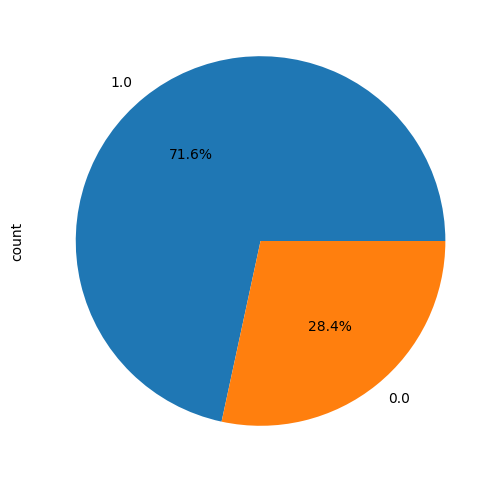

In [ ]:
plot_pie_values_col(ds=iter_imp_df, column="sex")

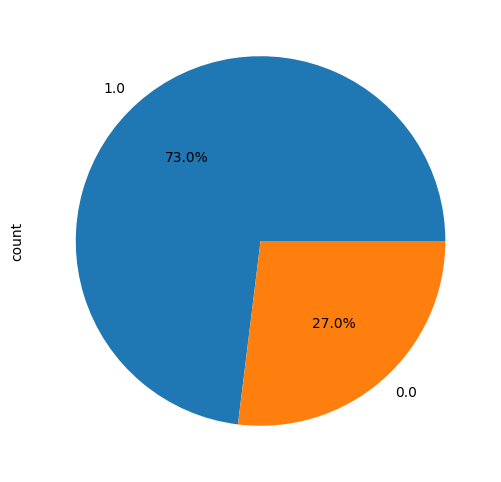

In [ ]:
plot_pie_values_col(ds=randsamp, column="sex")

In [ ]:
stratsamp = iter_imp_df.groupby("sex", group_keys=False).apply(
    lambda x: x.sample(frac=0.2)
)
stratsamp

Id   age  chest_pain_type  cholesterol  exercise_angina  \
1135  2135.0  57.0         4.000000        299.0              0.0   
372   1372.0  34.0         2.000000        212.0              0.0   
453   1453.0  54.0         3.000000        200.0              0.0   
494   1494.0  52.0         3.000000        270.0              0.0   
577   1577.0  62.0         3.000000        258.0              0.0   
...      ...   ...              ...          ...              ...   
1024  2024.0  62.0         2.000000        213.0              0.0   
730   1730.0  58.0         2.650015        236.0              0.0   
210   1210.0  41.0         2.000000        206.0              0.0   
1064  2064.0  52.0         2.000000        201.0              0.0   
1117  2117.0  55.0         2.000000         -3.0              0.0   

      fasting_blood_sugar  max_heart_rate   oldpeak  resting_bp_s  \
1135                  0.0           159.0  0.050407         127.0   
372                   0.0           192.0  0.677054         118.0   
453                   0.0           163.0 -0.052670         159.0   
494                   0.0           140.0 -0.008108         125.0   
577                   0.0            97.0  1.205433         130.0   
...                   ...             ...       ...           ...   
1024                  1.0           141.0 -0.051026         128.0   
730                   0.0           156.0  0.081113         100.0   
210                   0.0           133.0  0.016203         135.0   
1064                  0.0           159.0  0.751931         134.0   
1117                  0.0           150.0  0.193929         139.0   

      resting_ecg  sex  st_slope      synt  
1135          2.0  0.0       1.0  0.328025  
372           0.0  0.0       1.0  0.787559  
453           0.0  0.0       1.0  0.707382  
494           0.0  0.0       1.0  0.188919  
577           0.0  0.0       2.0  0.657870  
...           ...  ...       ...       ...  
1024          2.0  1.0       1.0  0.401667  
730           0.0  1.0       1.0  0.895057  
210           0.0  1.0       2.0  0.738978  
1064          0.0  1.0       1.0  0.147804  
1117          1.0  1.0       1.0  0.759383  

[258 rows x 13 columns]

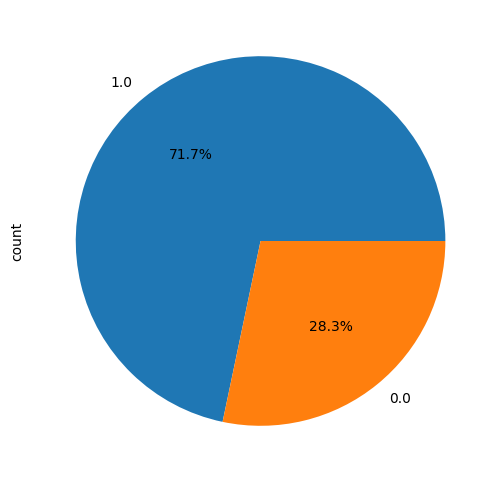

In [ ]:
plot_pie_values_col(stratsamp, column="sex")

## Principal Component Analysis

In [ ]:
# Decomposition of PCA
pca_decomp = PCA(n_components=2, whiten=True, random_state=RANDOM_STATE)
pca_decomp = pca_decomp.fit(iter_imp_df)

# Dataset PCA as Numpy array
iter_imp_pca_arr = pca_decomp.transform(iter_imp_df)

<Axes: >

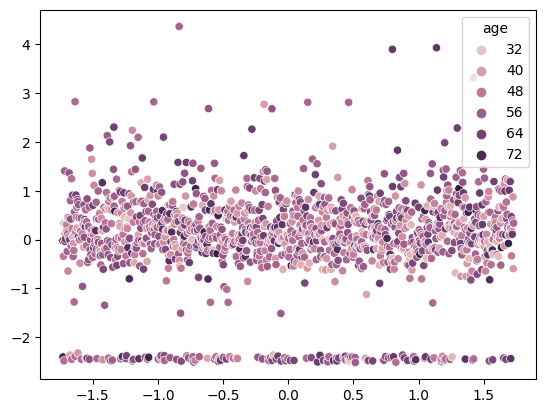

In [ ]:
# Plot the pca clustered by age
sns.scatterplot(
    x=iter_imp_pca_arr[:, 0], y=iter_imp_pca_arr[:, 1], hue=iter_imp_df["age"]
)

## Feature Subset Selection

Techniques:
- Brute-force approach: Try all possible feature subsets as input to data mining algorithm
- Embedded approaches: Feature selection occurs naturally as part of the data mining algorithm
- Filter approaches: Features are selected before data mining algorithm is run
- Wrapper approaches: Use the data mining algorithm as a black box to find best subset of attributes

Techniques:
- Univariate approach:
    - KBest: Select features according to the k highest scores in univariate fashion (default using Analysis of Variance, aka ANOVA, scores).
- ModelBased approach: Feature selection using an estimator for feature ranking
    - Recursive Feature Elimination: Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features.
    - Sequential Feature Selection: This Sequential Feature Selector adds (forward selection) or removes (backward selection) features to form a feature subset in a greedy fashion.
    - Select From Model: Meta-transformer for selecting features based on importance weights.

### Univariate Approach

In [ ]:
def get_feature_univ_scores(univ_fselector, columns, sort_by: str = "score"):
    return pd.DataFrame(
        data=[univ_fselector.scores_, univ_fselector.pvalues_],
        index=["score", "pvalue"],
        columns=columns,
    ).T.sort_values(by=sort_by, ascending=False)

#### Select KBest

In [ ]:
# Create the feature selector
kbest = SelectKBest(k=3)
kbest.fit(iter_imp_df, target)

SelectKBest(k=3)

In [ ]:
# Print selected columns
iter_imp_df.columns[kbest.get_support()]

Index(['chest_pain_type', 'exercise_angina', 'st_slope'], dtype='object')

In [ ]:
# Feature selection scores and pvalues analysis
get_feature_univ_scores(kbest, iter_imp_df.columns, sort_by="score")

score        pvalue
st_slope             471.727403  1.761882e-89
exercise_angina      418.713791  6.904569e-81
chest_pain_type      346.734019  8.821552e-69
oldpeak              296.106928  6.115583e-60
max_heart_rate       254.102044  2.193851e-52
sex                  138.970318  1.513454e-30
age                   72.270300  5.082030e-17
fasting_blood_sugar   60.132881  1.781228e-14
cholesterol           53.832334  3.833734e-13
resting_bp_s          28.966881  8.726983e-08
resting_ecg            3.820035  5.085745e-02
Id                     2.051740  1.522729e-01
synt                   0.679586  4.098806e-01

In [ ]:
# Transform dataset selection columns
kbest.transform(iter_imp_df)

array([[2., 0., 1.],
       [3., 0., 2.],
       [3., 0., 2.],
       ...,
       [2., 0., 1.],
       [2., 0., 1.],
       [3., 0., 1.]])

### ModelBased Approach

#### Recursive Feature Elimination (Based On Regression)

In [ ]:
def get_feature_rfe_ranking(
    mb_fselector, columns,
):
    return pd.DataFrame(
        data=[mb_fselector.ranking_], index=["ranking"], columns=columns,
    ).T.sort_values(by="ranking", ascending=True)

In [ ]:
# Create the RecursiveFeatureElimination selector
rfe = RFE(
    estimator=LinearRegression(), n_features_to_select=K_FEATURES, step=1)
rfe.fit(iter_imp_df, target)

RFE(estimator=LinearRegression(), n_features_to_select=3)

In [ ]:
# Print selected columns
iter_imp_df.columns[rfe.support_]

Index(['exercise_angina', 'sex', 'st_slope'], dtype='object')

In [ ]:
# Analyze feature ranking
get_feature_rfe_ranking(rfe, iter_imp_df.columns)

ranking
exercise_angina            1
sex                        1
st_slope                   1
fasting_blood_sugar        2
chest_pain_type            3
oldpeak                    4
resting_ecg                5
synt                       6
max_heart_rate             7
resting_bp_s               8
age                        9
cholesterol               10
Id                        11

In [ ]:
rfe.transform(iter_imp_df)

array([[0., 1., 1.],
       [0., 1., 2.],
       [0., 0., 2.],
       ...,
       [0., 1., 1.],
       [0., 1., 1.],
       [0., 1., 1.]])

#### Sequential Feature Selection (Based on Classification)

In [ ]:
# Create the RecursiveFeatureElimination selector
sfs = SequentialFeatureSelector(
    estimator=DecisionTreeClassifier(max_depth=4),
    n_features_to_select=K_FEATURES,
    cv=5,
)
sfs.fit(iter_imp_df, target)

SequentialFeatureSelector(estimator=DecisionTreeClassifier(max_depth=4),
                          n_features_to_select=3)

In [ ]:
# Print selected columns
iter_imp_df.columns[sfs.support_]

Index(['chest_pain_type', 'oldpeak', 'st_slope'], dtype='object')

In [ ]:
sfs.transform(iter_imp_df)

array([[ 2.00000000e+00, -5.10264162e-02,  1.00000000e+00],
       [ 3.00000000e+00,  1.62659934e+00,  2.00000000e+00],
       [ 3.00000000e+00,  9.68111287e-01,  2.00000000e+00],
       ...,
       [ 2.00000000e+00, -1.13716870e-02,  1.00000000e+00],
       [ 2.00000000e+00, -2.52410253e-02,  1.00000000e+00],
       [ 3.00000000e+00, -1.95834940e-03,  1.00000000e+00]])

#### Select From Model

In [ ]:
# Create the SelectFromModel selector
sfm = SelectFromModel(estimator=Lasso(), max_features=K_FEATURES)
sfm.fit(iter_imp_df, target)

SelectFromModel(estimator=Lasso(), max_features=3)

In [ ]:
# Print selected columns
iter_imp_df.columns[sfm.get_support()]

Index(['cholesterol', 'max_heart_rate', 'resting_bp_s'], dtype='object')

In [ ]:
sfm.transform(iter_imp_df)

array([[213., 141., 128.],
       [  2., 115., 159.],
       [183., 156., 161.],
       ...,
       [294., 161., 121.],
       [161., 183., 120.],
       [245., 173., 131.]])

## Feature Construction

In [ ]:
# Create a new feature called relative_bp_s as the ratio between resting blood pressure and cholesterol
iter_imp_df["bp_s_chol"] = iter_imp_df["resting_bp_s"] / (
    iter_imp_df["cholesterol"] + 1e-7
)
iter_imp_df["bp_s_chol"]

0        0.600939
1       79.499996
2        0.879781
3        0.491840
4      -30.000001
          ...    
1296     0.709251
1297     0.517928
1298     0.411565
1299     0.745342
1300     0.534694
Name: bp_s_chol, Length: 1301, dtype: float64

## Attribute Transformation

In [ ]:
# Apply logaritmic transformation and create a new transformed column
iter_imp_df["transformed_mhr"] = iter_imp_df["max_heart_rate"].apply(
    lambda x: max(min(x - x / np.sqrt(x), 120), 90)
)

<Axes: >

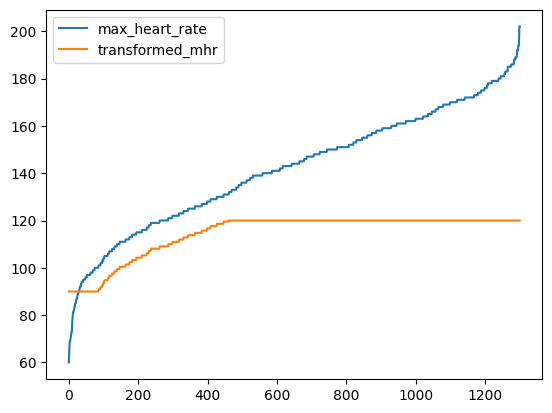

In [ ]:
# Visualize the current transformation
iter_imp_df[["max_heart_rate", "transformed_mhr"]].sort_values(
    by="max_heart_rate", ignore_index=True
).plot.line()

## Data profiling


In [ ]:
!pip freeze |grep pandas-profiling


pandas-profiling==3.6.6
ydata-profiling @ https://github.com/ydataai/pandas-profiling/archive/master.zip#sha256=cd7e48c8aee3ace9d9815e6bdcbd01e8ac4f938b7746c68b39a0e49e60299fde


In [ ]:
pp.ProfileReport(dataset)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
pip install ydata-profiling

In [ ]:
from ydata_profiling import ProfileReport

In [ ]:
# Generate Pandas Profiling Report
profile = ProfileReport(dataset, explorative=True)
display(profile)